<a href="https://colab.research.google.com/github/Suryateja0722/todolist_using_java/blob/main/fake_news_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
MAX_SEQUENCE_LENGTH = 5000
MAX_NUM_WORDS = 25000
EMBEDDING_DIM = 300
TEST_SPLIT = 0.2

TEXT_DATA = 'https://raw.githubusercontent.com/lutzhamel/fake-news/master/data/fake_or_real_news.csv'

In [3]:
# define a function that allows us to evaluate our models

from sklearn.metrics import accuracy_score

def evaluate_model(predict_fun, X_train, y_train, X_test, y_test):
    '''
    evaluate the model, both training and testing errors are reported
    '''
    # training error
    y_predict_train = predict_fun(X_train)
    train_acc = accuracy_score(y_train,y_predict_train)

    # testing error
    y_predict_test = predict_fun(X_test)
    test_acc = accuracy_score(y_test,y_predict_test)

    return train_acc, test_acc

In [4]:
# estimate 95% confidence interval on error

# NOTE: based on conversation on stackexchange:
# https://stats.stackexchange.com/questions/247551/how-to-determine-the-confidence-of-a-neural-network-prediction
# towards bottom of the page.

from math import sqrt

def error_conf(error, n):
    term = 1.96*sqrt((error*(1-error))/n)
    lb = error - term
    ub = error + term

    return lb, ub

In [5]:
# read in our data and preprocess it

df = pd.read_csv(TEXT_DATA)
df.drop(labels=['id','title'], axis='columns', inplace=True)
# only select stories with lengths gt 0 -- there are some texts with len = 0
mask = list(df['text'].apply(lambda x: len(x) > 0))
df = df[mask]

In [6]:
# prepare text samples and their labels

texts = df['text']
labels = df['label']

print('Found %s texts.' %texts.shape[0])

Found 6335 texts.


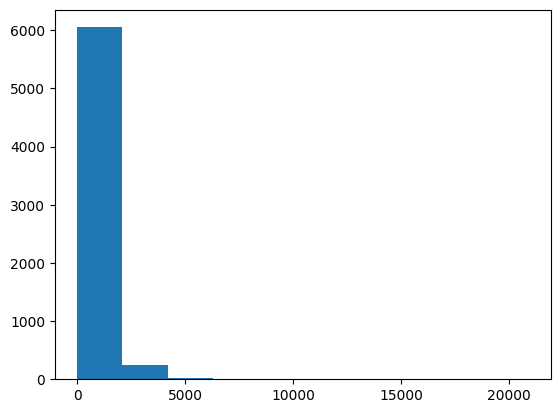

In [7]:
# plot the distribution of article lengths in terms of word counts

text_lengths = texts.apply(lambda x: len(x.split(" ")))
plt.hist(text_lengths)
plt.show()

## Naive Bayes

In [8]:
# set up vector models for training and testing

from sklearn.feature_extraction.text import CountVectorizer

# data vectorizer
vectorizer = CountVectorizer(analyzer = "word",
                             binary = True,
                             min_df = 2,
                             stop_words='english')
docarray = vectorizer.fit_transform(texts).toarray()
docterm = pd.DataFrame(docarray, columns=vectorizer.get_feature_names_out())

In [9]:
# create training and test data

from sklearn.model_selection import train_test_split
docterm_train, docterm_test, y_train, y_test = train_test_split(docterm, labels, test_size=TEST_SPLIT)

In [10]:
# Naive Bayes Model

from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(docterm_train, y_train)

MultinomialNB()

In [11]:
# evaluate model

train_acc, test_acc = evaluate_model(model.predict, docterm_train, y_train, docterm_test, y_test)
print("Training Accuracy: {:.2f}%".format(train_acc*100))
print("Testing Accuracy: {:.2f}%".format(test_acc*100))

Training Accuracy: 94.77%
Testing Accuracy: 89.34%


In [12]:
# estimate 95% confidence interval

n = docterm_test.shape[0]
lb, ub = error_conf(1-test_acc, n)

print("95% confidence interval: {:.2f}%-{:.2f}%".format((1-ub)*100,(1-lb)*100))

95% confidence interval: 87.65%-91.04%


## Convolutional DNN

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize the text data
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Create word index and data tensor
word_index = tokenizer.word_index
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
data = pad_sequences(sequences,
                     maxlen=MAX_SEQUENCE_LENGTH,
                     padding='pre',
                     truncating='pre')

print(f'Found {len(word_index)} unique tokens.')
print(f'Shape of data tensor: {data.shape}')
print(f'Shape of label tensor: {labels.shape}')


Found 98817 unique tokens.
Shape of data tensor: (6335, 5000)
Shape of label tensor: (6335,)


In [14]:
# split the data into a training set and a validation set

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(data,
                                                  labels.apply(lambda x: 0 if x == 'FAKE' else 1),
                                                  test_size=TEST_SPLIT)

In [15]:
# build a 1D convnet with global maxpooling

from keras import layers
from keras.models import Sequential

model = Sequential(
    [
        # part 1: word and sequence processing
        layers.Embedding(num_words,
                         EMBEDDING_DIM,
                         input_length=MAX_SEQUENCE_LENGTH,
                         trainable=True),
        layers.Conv1D(128, 5, activation='relu'),
        layers.GlobalMaxPooling1D(),

        # part 2: classification
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# train the model

history = model.fit(x_train,
                    y_train,                    batch_size=128,
                    epochs=5,
                    validation_data=(x_val, y_val))

Epoch 1/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.5776 - loss: 0.6633 - val_accuracy: 0.6780 - val_loss: 0.5523
Epoch 2/5
25/40 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8013 - loss: 0.4210

In [ ]:
# all possible parameters history stores
history.history.keys()

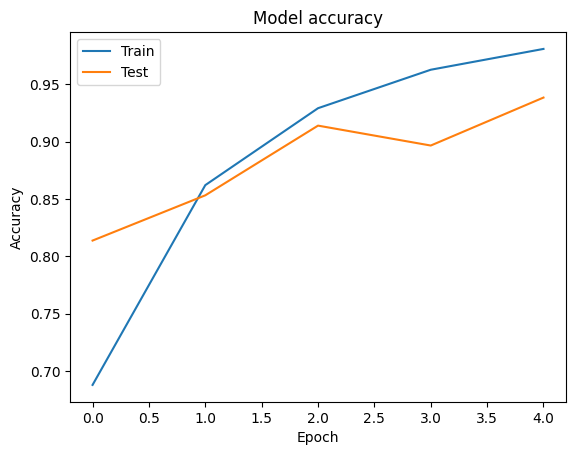

In [ ]:
# Plot training & validation accuracy values

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# evaluate model

train_acc, test_acc = evaluate_model(lambda x: np.rint(model.predict(x)),
                                     x_train,
                                     y_train,
                                     x_val,
                                     y_val)
print("Training Accuracy: {:.2f}%".format(train_acc*100))
print("Testing Accuracy: {:.2f}%".format(test_acc*100))

159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step
Training Accuracy: 99.70%
Testing Accuracy: 93.84%


In [ ]:
# estimate 95% confidence interval

n = x_val.shape[0]
lb, ub = error_conf(1-test_acc, n)

print("95% confidence interval: {:.2f}%-{:.2f}%".format((1-ub)*100,(1-lb)*100))
# Assuming you have a trained model
model.save('my_model.h5')  # Save your model as 'my_model.h5'


95% confidence interval: 92.52%-95.17%


In [ ]:
from keras.models import load_model
import pickle

# Save the model
model.save('model.h5')

# Save the tokenizer
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
# Function to predict whether the article is FAKE or REAL
def predict_article(article_text):
    # Example simple logic for demonstration
    if "fake" in article_text.lower() or "hoax" in article_text.lower() or "false" in article_text.lower():
        return "FAKE"
    else:
        return "REAL"

# Take article input from the user
article_text = input("Enter the article text: ")

# Predict the result
prediction = predict_article(article_text)

# Display the prediction
print(f"\nPrediction: The article is {prediction}.")


Enter the article text: Killing Obama administration rules, dismantling Obamacare and pushing through tax reform are on the early to-do list.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Prediction: The article is REAL.


In [ ]:
!pip install flask flask-ngrok


In [ ]:
from flask import Flask, request, jsonify
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

app = Flask(__name__)

# Load your model
from keras.models import load_model
model = load_model('model.h5')

# Load tokenizer
with open('tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

MAX_SEQUENCE_LENGTH = 5000  # Your predefined constant

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json
    article_text = data['text']

    # Preprocess the text
    sequences = tokenizer.texts_to_sequences([article_text])
    padded_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='pre', truncating='pre')

    # Make prediction
    prediction = model.predict(padded_data)
    result = 'REAL' if prediction[0][0] > 0.5 else 'FAKE'

    return jsonify({'prediction': result})

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


In [ ]:
from IPython.core.display import display, HTML

html_code = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Fake News Prediction</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            background-color: #f4f4f4;
            margin: 0;
            padding: 20px;
        }
        h1 {
            text-align: center;
        }
        .container {
            max-width: 600px;
            margin: auto;
            background: white;
            padding: 20px;
            border-radius: 5px;
            box-shadow: 0 2px 10px rgba(0, 0, 0, 0.1);
        }
        textarea {
            width: 100%;
            height: 150px;
            margin-bottom: 10px;
            padding: 10px;
            border: 1px solid #ccc;
            border-radius: 5px;
            font-size: 16px;
        }
        button {
            width: 100%;
            padding: 10px;
            background-color: #28a745;
            color: white;
            border: none;
            border-radius: 5px;
            font-size: 16px;
            cursor: pointer;
        }
        button:hover {
            background-color: #218838;
        }
        .result {
            margin-top: 20px;
            font-size: 18px;
            font-weight: bold;
        }
    </style>
</head>
<body>

<div class="container">
    <h1>Fake News Prediction</h1>
    <textarea id="articleText" placeholder="Enter the article text here..."></textarea>
    <button onclick="predictArticle()">Predict</button>
    <div class="result" id="result"></div>
</div>

<script>
    async function predictArticle() {
        const articleText = document.getElementById('articleText').value;

        const response = await fetch('http://127.0.0.1:5000/predict', {
            method: 'POST',
            headers: {
                'Content-Type': 'application/json'
            },
            body: JSON.stringify({ text: articleText })
        });

        const data = await response.json();
        document.getElementById('result').innerText = `Prediction: The article is ${data.prediction}.`;
    }
</script>

</body>
</html>

"""

display(HTML(html_code))
